In [6]:
from vits.models import MultiPeriodDiscriminator as TeacherMultiPeriodDiscriminator
from vits.models import SynthesizerTrn as TeacherSynthesizerTrn
from vits import utils
from models import MultiPeriodDiscriminator as StudentMultiPeriodDiscriminator
from models import Encoder, Decoder
from utils import num_params, get_hparams_from_file, load_checkpoint
from text import symbols, text_to_sequence
import matplotlib.pyplot as plt
import IPython.display as ipd
import commons
import torch

# student model load
hps_enc = get_hparams_from_file('./logs/kss/config_enc.json')
hps_dec = get_hparams_from_file('./logs/kss/config_dec.json')

net_enc = Encoder(
    n_symbols=len(symbols), 
    n_spec_channels=hps_enc.data.filter_length // 2 + 1, 
    n_speakers=hps_enc.data.n_speakers, 
    **hps_enc.model)
_ = load_checkpoint("./logs/kss/ENCODER_111000.pth", net_enc, None)

net_dec = Decoder(
    n_speakers=hps_dec.data.n_speakers, 
    **hps_dec.model
)
_ = load_checkpoint("./logs/kss/DECODER_143000.pth", net_dec, None)

# teacher model load
teacher_model_config = './vits/logs/kss_v1/config.json'
teacher_model_dir = './vits/logs/kss_v1'
hps_teacher = utils.get_hparams_from_file(teacher_model_config)

net_teacher = TeacherSynthesizerTrn(
  len(symbols),
  hps_teacher.data.filter_length // 2 + 1,
  hps_teacher.train.segment_size // hps_teacher.data.hop_length,
  n_speakers=hps_teacher.data.n_speakers,
  **hps_teacher.model)
net_teacher, _, _, _ = utils.load_checkpoint(
  utils.latest_checkpoint_path(teacher_model_dir, "G_*.pth"), net_teacher, None)

./vits/logs/kss_v1/G_59000.pth


In [7]:
def get_text(text, hps):
    # text_norm = text_to_sequence(text, hps.data.text_cleaners)
    text_norm = text_to_sequence(text)
    if hps.data.add_blank:
        text_norm = commons.intersperse(text_norm, 0)
    text_norm = torch.LongTensor(text_norm)
    return text_norm

## Encoder

In [8]:
print(num_params(net_enc))
print(num_params(net_enc.aligner))

Trainable Parameters: 6.143M
6142593
Trainable Parameters: 2.682M
2681547


In [9]:
test = '안녕하세요? 만나서 반갑습니다.'
sid = 0
stn_tst = get_text(test, hps_enc)
net_enc.eval()
with torch.no_grad():
    x_tst = stn_tst.unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)])
    sid = torch.LongTensor([sid])
    (z_hat, m_hat, logs_hat, attn_h), (x_mask, y_mask, attn_mask), g = net_enc.infer(
        x_tst, x_tst_lengths, sid=sid, noise_scale=.667, noise_scale_w=0.8, length_scale=1)

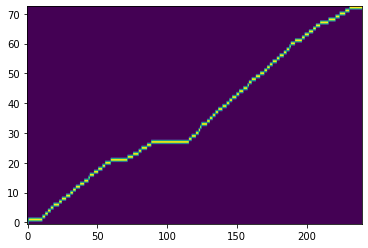

In [10]:
net_teacher.eval()
with torch.no_grad():
    audio = net_teacher.infer_decoder_teacher_mode(z_hat, g)[0][0].data.cpu().float().numpy()
    
h_a = attn_h.squeeze(1).transpose(1,2)
plt.imshow(h_a[0].detach().cpu().numpy(), origin='lower', aspect='auto')
plt.show()
ipd.display(ipd.Audio(audio, rate=hps_teacher.data.sampling_rate, normalize=False))

## Decoder

In [11]:
# Generator
params_gen_s = num_params(net_dec, print_out=True)
params_gen_t = num_params(net_teacher.dec, print_out=True)
reduce_r = (1-round(params_gen_s/params_gen_t, 3))*100

print(reduce_r)

Trainable Parameters: 1.300M
Trainable Parameters: 14.469M
91.0


In [12]:
# Discriminator
disc_s = StudentMultiPeriodDiscriminator()
disc_t = TeacherMultiPeriodDiscriminator()

params_disc_s = num_params(disc_s, print_out=True)
params_disc_t = num_params(disc_t, print_out=True)
reduce_r = (1-round(params_disc_s/params_disc_t, 3))*100

print(reduce_r)

Trainable Parameters: 12.396M
Trainable Parameters: 46.747M
73.5


In [13]:
net_dec.eval()
with torch.no_grad():
    audio = net_dec(z_hat, g)[0][0].data.cpu().float().numpy()
ipd.display(ipd.Audio(audio, rate=hps_dec.data.sampling_rate, normalize=False))    

## Encoder-Decoder

In [14]:
# student model
from tqdm.auto import tqdm
import time

text = '안녕하세요? 만나서 반갑습니다.'
sid = 0
stn_tst = get_text(text, hps_enc)

num_infers = 1
net_enc.eval()
net_dec.eval()
times_s = []
with torch.no_grad():
    x_tst = stn_tst.unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)])
    sid = torch.LongTensor([sid])
    
    (z_hat, *_), _, g = net_enc.infer(x_tst, x_tst_lengths, sid=sid, noise_scale=.667, noise_scale_w=0.8, length_scale=1)
    for _ in tqdm(range(num_infers), total=num_infers):
        start_time = time.time()
        audio = net_dec(z_hat, g)[0][0].data.cpu().float().numpy()
        end_time = time.time() - start_time
        times_s.append(end_time)
ipd.display(ipd.Audio(audio, rate=hps_dec.data.sampling_rate, normalize=False))
print(end_time)

  0%|          | 0/1 [00:00<?, ?it/s]

0.1795666217803955


In [15]:
# teacher model
from tqdm.auto import tqdm
import time

text = '안녕하세요? 만나서 반갑습니다.'
sid = 0
stn_tst = get_text(text, hps_teacher)

num_infers = 1
net_teacher.eval()
times_t = []
with torch.no_grad():
    x_tst = stn_tst.unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)])
    sid = torch.LongTensor([sid])
    for _ in tqdm(range(num_infers), total=num_infers):
        start_time = time.time()
        audio = net_teacher.infer(x_tst, x_tst_lengths, sid=sid, noise_scale=.667, noise_scale_w=0.8, length_scale=1)[0][0,0].data.cpu().float().numpy()
        end_time = time.time() - start_time
        times_t.append(end_time)
ipd.display(ipd.Audio(audio, rate=hps_teacher.data.sampling_rate, normalize=False))
print(end_time)

  0%|          | 0/1 [00:00<?, ?it/s]

0.8170967102050781


## Session

In [3]:
from models_wrapper import NixttsTorchSession
import IPython.display as ipd

sess = NixttsTorchSession(
    enc_hps_path='./logs/kss/config_enc.json',
    dec_hps_path='./logs/kss/config_dec.json',
    enc_ckpt_path='./logs/kss/ENCODER_111000.pth',
    dec_ckpt_path='./logs/kss/DECODER_143000.pth'
)

In [5]:
text = '안녕하세요? 만나서 반갑습니다.'
audio = sess(text)
display(ipd.Audio(audio, rate=sess.decoder_wrapper.hps.data.sampling_rate, normalize=False))